### v2 - use list of predictions from stage 1 model

In [1]:
# !pip install catboost shap

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from __future__ import print_function, absolute_import

from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor,CatBoost
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import gc
import matplotlib.pyplot as plt
import shap
shap.initjs()

from copy import deepcopy
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, GroupKFold
from tensorflow.keras.metrics import TopKCategoricalAccuracy, Precision, SparseTopKCategoricalAccuracy # @4
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from sklearn.metrics import top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)
# from sklearn.linear_model import  LogisticRegressionCV
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# from pytorch_tabnet.tab_model import TabNetClassifier
# from pytorch_tabnet.pretraining import TabNetPretrainer
# from pytorch_tabnet.metrics import Metric
# import torch

%matplotlib inline

pd.set_option("display.max_columns", 90)

In [4]:
# ## https://www.tensorflow.org/guide/mixed_precision ## TF mixed precision - pytorch requires other setup
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# ## will need to correct in places, e.g.: 
# ## outputs = layers.Activation('softmax', dtype='float32', name='predictions')(x)

#### Features to add:
* Lag 
* Rank (popularity) of city, country (in general, +- given booker country)
* Count of hotel; user, trip size ? (may be leaky )
* Seasonal features - Holidays? , datetime

Aggregate feats:
* user changed country? last booking (lag 1) country change? 
* max/min/avg popularity rank of previous locations visited



We should create a dictionary of the rank, count, city/country etc' feats, so we can easily merge them when making more "negative" samples/feats for ranking.


* Consider using a df2 of df without dates + drop_duplicates, +- without user/trip id (After calcing that) .


Leaky or potentially leaky (Dependso n test set): 
* Target freq features - frequency of target city, given source county +- affiliate +- month of year +- given country (and interactions of target freq). 
    * Risk of leaks - depends of test data has temporal split or not. 
    * cartboost can do target encode, but this lets us do it for interactions, e.g. target city freq given the 2 countries and affiliate.
    * beware overfitting! 

In [5]:
max_epochs = 500
FASTRUN = False #True False

if FASTRUN:
    max_epochs = 2

In [6]:
TARGET_COL = "label"
RUN_TABNET = False
# most basic categorical columns , without 'user_id', , 'utrip_id' ordevice_class - used for count encoding/filtering
BASE_CAT_COLS = ['city_id',  'affiliate_id', 'booker_country', 'hotel_country']

### features to get lags for. Not very robust. May want different feats for lags before -1
LAG_FEAT_COLS = ['city_id', 
#                  'device_class',
       'affiliate_id',
#                  'booker_country',
                 'hotel_country', 
       'duration', 'same_country', 
#                  'checkin_weekday',
       'checkin_week',
#         'checkout_weekday',
       'city_id_count', 'affiliate_id_count',
                 'hotel_country_count', 
#                  'checkin_week_count',
                 'city_id_rank_by_hotel_country',
       'city_id_rank_by_booker_country', 
                 'city_id_rank_by_affiliate',
#        'affiliate_id_rank_by_hotel_country',
#        'affiliate_id_rank_by_booker_country', 
#        'booker_country_rank_by_hotel_country',
#        'booker_country_rank_by_booker_country',
#        'booker_country_rank_by_affiliate',
#        'hotel_country_rank_by_hotel_country',
#        'hotel_country_rank_by_booker_country',
#        'hotel_country_rank_by_affiliate',
#        'checkin_month_rank_by_hotel_country',
#        'checkin_month_rank_by_booker_country',
#        'checkin_month_rank_by_affiliate'
                ]

CAT_FEAT_NAMES = ["booker_country", "device_class","affiliate_id",
                  "city_id","hotel_country",
#                   "utrip_id", ## changed
#                   "user_id", ## ? could use lower dim - depends on train/test overlap
                  "checkin_week",#"checkout_week",
#                     "checkin_weekday",
    "lag1_city_id","lag1_hotel_country","lag1_affiliate_id", #"lag1_device_class",
     "lag2_city_id","lag2_hotel_country","lag2_affiliate_id",#"lag2_device_class",
#       "lag3_city_id","lag3_booker_country","lag3_hotel_country","lag3_affiliate_id","lag3_device_class",
                  "first_hotel_country","first_city_id"
                 ]

TRAIN_FILE_PATH = "booking_train_set.csv" #"/content/drive/MyDrive/booking_wisdom/booking_train_set.csv" #"booking_train_set.csv"
LIST_FILE_PATH =  "list_booking_train.csv.gz"#"/content/drive/MyDrive/booking_wisdom/list_booking_train.csv.gz" #"list_booking_train.csv.gz"

In [7]:
# https://stackoverflow.com/questions/33907537/groupby-and-lag-all-columns-of-a-dataframe
# https://stackoverflow.com/questions/62924987/lag-multiple-variables-grouped-by-columns
## lag features with groupby over many columns: 
def groupbyLagFeatures(df:pd.DataFrame,lag:[]=[1,2],group="utrip_id",lag_feature_cols=[]):
    """
    lag features with groupby over many columns
    https://stackoverflow.com/questions/62924987/lag-multiple-variables-grouped-by-columns"""
    if len(lag_feature_cols)>0:
        df=pd.concat([df]+[df.groupby(group)[lag_feature_cols].shift(x).add_prefix('lag'+str(x)+"_") for x in lag],axis=1)
    else:
         df=pd.concat([df]+[df.groupby(group).shift(x).add_prefix('lag'+str(x)+"_") for x in lag],axis=1)
    return df

def groupbyFirstLagFeatures(df:pd.DataFrame,group="user_id",lag_feature_cols=[]):
    """
    Get  first/head value lag-like of features with groupby over columns. Assumes sorted data!
    """
    if len(lag_feature_cols)>0:
        df=pd.concat([df]+[df.groupby(group)[lag_feature_cols].transform("first").add_prefix("first_")],axis=1)
    else:
#          df=pd.concat([df]+[df.groupby(group).first().add_prefix("first_")],axis=1)
        df=pd.concat([df]+[df.groupby(group).transform("first").add_prefix("first_")],axis=1)
    return df

######## Get n most popular items, per group
def most_popular(group, n_max=4):
    """Find most popular hotel clusters by destination
    Define a function to get most popular hotels for a destination group.

    Previous version used nlargest() Series method to get indices of largest elements. But the method is rather slow.
    Source: https://www.kaggle.com/dvasyukova/predict-hotel-type-with-pandas
    """
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1] # remove square brackets

from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_4_accuracy(y_true, y_pred):
    """will only work if doing multiclass predictions"""
    return top_k_categorical_accuracy(y_true, y_pred, k=4)

## https://codereview.stackexchange.com/questions/149306/select-the-n-most-frequent-items-from-a-pandas-groupby-dataframe
# https://stackoverflow.com/questions/52073054/group-by-a-column-to-find-the-most-frequent-value-in-another-column
## can get modes (sorted)
# https://stackoverflow.com/questions/50592762/finding-most-common-values-with-pandas-groupby-and-value-counts
## df.groupby('tag')['category'].agg(lambda x: x.value_counts().index[0])
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
# source2.groupby(['Country','City'])['Short name'].agg(pd.Series.mode)


In [8]:
dtypes_dict = {
#     "utrip_id":"category",
    "city_id":"int32",
    "rank":"int16",
    "label": "int8",#"uint8",
    "affiliate_id":"int16",
#     "device_class":"category",
#     "booker_country":"string", ## category would save more memory but intereferes with feature engineering
#     "hotel_country":"string"
}

In [9]:
if FASTRUN:
    df = pd.read_csv(TRAIN_FILE_PATH,
                     nrows=90,
                     index_col=[0],
                     parse_dates=["checkin","checkout"],infer_datetime_format=True, dtype=dtypes_dict)
else:
    df = pd.read_csv(TRAIN_FILE_PATH,
                     index_col=[0],
                     nrows=160_500,
                     parse_dates=["checkin","checkout"],infer_datetime_format=True, dtype=dtypes_dict)

## list of candidate predictions (100 per utrip_id)
df_list = pd.read_csv(LIST_FILE_PATH,
                        usecols=[0,2,3], # skip city_id col
                        dtype=dtypes_dict)
print("rank of labels (target =1):")
print(df_list.loc[df_list["label"]==1]["rank"].describe(percentiles=[.25,.5,.75,.9,.95,.99]))

print(df_list.shape[0])

if FASTRUN:
#     df_list_1 = df_list.loc[(df_list["rank"]<=20) | (df_list["label"]==1)]    
#     df_list_2 = df_list.loc[(df_list["rank"]>20) & (df_list["label"]==0)].groupby(["utrip_id"]).sample(n=5) # #groupby sample is slow
#     df_list = pd.concat([df_list_1,df_list_2])
#     del df_list_1,df_list_2
    df_list = df_list.loc[df_list["rank"]<=15]
else:
    # # ## HACK due to running out of mempory ! sample of data 
    df_list_1 = df_list.loc[(df_list["rank"]<=40) | (df_list["label"]==1)]    
    df_list_2 = df_list.loc[(df_list["rank"]>40) & (df_list["label"]==0)].groupby(["utrip_id"]).sample(n=12,random_state=42)
    df_list = pd.concat([df_list_1,df_list_2])
    del df_list_1,df_list_2
    gc.collect()

print("df list shape",df_list.shape[0])

df_list.set_index("utrip_id",inplace=True)
                     
df.sort_values(["user_id","checkin"],inplace=True)
# df_list.set_index("utrip_id",inplace=True)
display(df)
display(df_list)

rank of labels (target =1):
count    191671.000000
mean         11.927016
std          18.841272
min           0.000000
25%           1.000000
50%           4.000000
75%          14.000000
90%          37.000000
95%          56.000000
99%          87.000000
max          99.000000
Name: rank, dtype: float64
20325800
df list shape 10789848


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
117277,136,2016-09-20,2016-09-22,52933,desktop,9924,The Devilfire Empire,Osterlich,136_4
117278,136,2016-09-22,2016-09-23,51685,desktop,9924,The Devilfire Empire,Osterlich,136_4
117279,136,2016-09-23,2016-09-24,43323,desktop,9924,The Devilfire Empire,Osterlich,136_4
117280,136,2016-09-24,2016-09-26,55990,desktop,9924,The Devilfire Empire,Osterlich,136_4
117281,136,2016-09-26,2016-09-27,46411,desktop,9924,The Devilfire Empire,Osterlich,136_4
...,...,...,...,...,...,...,...,...,...
98856,6257762,2016-10-10,2016-10-12,24912,desktop,9924,The Devilfire Empire,Cobra Island,6257762_1
64257,6257973,2016-08-08,2016-08-09,53238,mobile,4541,Gondal,Rolisica,6257973_1
64258,6257973,2016-08-09,2016-08-11,13161,mobile,2436,Gondal,Rolisica,6257973_1
64259,6257973,2016-08-11,2016-08-12,6382,tablet,5755,Gondal,Rolisica,6257973_1


,rank,label
utrip_id,,
727105_1,0,0
727105_1,1,0
727105_1,2,0
727105_1,3,0
727105_1,4,0
...,...,...
999944_1,83,0
999944_1,86,0
999944_1,80,0


In [10]:
### todo : add "time since start (min date in data / "duration")"  
### todo : "time since start of trip (min date per trip "duration")"  
df["duration"] = ((df["checkout"] - df["checkin"]).dt.days).astype(int)
df["same_country"] = (df["booker_country"]==df["hotel_country"]).astype(int)

df["checkin_day"] = df["checkin"].dt.day
df["checkin_weekday"] = df["checkin"].dt.weekday
df["checkin_week"] = df["checkin"].dt.isocalendar().week.astype(int) ## week of year
df["checkin_month"] = df["checkin"].dt.month
df["checkin_year"] = df["checkin"].dt.year-2015
df["checkin_day_of_year"] = df["checkin"].dt.dayofyear  # day of year - may overfit , but will allow learning holidays and other checkins on that date 

# df["checkin_quarter"] = df["checkin"].dt.quarter # relatively redundant but may be used for "id"

# df["checkout_weekday"] = df["checkout"].dt.weekday
df["checkout_week"] = df["checkout"].dt.isocalendar().week.astype(int) ## week of year
df["checkout_day"] = df["checkout"].dt.day ## day of month

## cyclical datetime embeddings
## drop originakl variables? 
## TODO:L add for other variables, +- those that we'll embed (week?)

# df['checkin_weekday_sin'] = np.sin(df["checkin_weekday"]*(2.*np.pi/7))
# df['checkin_weekday_cos'] = np.cos(df["checkin_weekday"]*(2.*np.pi/7))

df['checkin_month_sin'] = np.sin((df["checkin_month"]-1)*(2.*np.pi/12))
df['checkin_month_cos'] = np.cos((df["checkin_month"]-1)*(2.*np.pi/12))

df['checkin_week_sin'] = np.sin((df["checkin_week"]-1)*(2.*np.pi/53))
df['checkin_week_cos'] = np.cos((df["checkin_week"]-1)*(2.*np.pi/53))

df.drop(["checkin_month"],axis=1,errors="ignore")

### time since first date in dataset (i.,e index proxy)
min_date = df["checkin"].min()
df["time_elapsed_global"] = (df["checkin"] - min_date).dt.days.astype(int)

# #############
# # last number in utrip id - probably which trip number it is:
# df["utrip_number"] = df["utrip_id"].str.split("_",expand=True)[1].astype(int)

### encode string columns - must be consistent with test data 
### IF we can concat test with train, we can just do a single transformation  for the NON TARGET cols
# obj_cols_list = df.select_dtypes("O").columns.values
obj_cols_list = ['device_class','booker_country','hotel_country'] # we could also define when loading data, dtype

# for c in obj_cols_list:
#     df[c] = df[c].astype("category")
#     df[c] = df[c].cat.codes.astype(int)


In [11]:
### replace rare variables (under 2 occurrences) with "-1" dummy
affiliates_counts = df["affiliate_id"].value_counts()
print("before:", affiliates_counts)
print("uniques",df["affiliate_id"].nunique())
affiliates_counts = affiliates_counts.to_dict()
# df["affiliate_id"] = df["affiliate_id"].where(df["affiliate_id"].apply(lambda x: x.map(x.value_counts()))>=3, -1)
df["affiliate_id"] = df["affiliate_id"].where(df["affiliate_id"].map(affiliates_counts)>3, -1)
df["affiliate_id"] = df["affiliate_id"].astype(int)

# print("after\n",df["affiliate_id"].value_counts())
print("affiliate_id nunique",df["affiliate_id"].nunique())

before: 9924    38429
359     23800
384     12022
9452    11498
4541     5791
        ...  
6361        1
2139        1
3928        1
9949        1
4094        1
Name: affiliate_id, Length: 1454, dtype: int64
uniques 1454
affiliate_id nunique 767


In [12]:
df.city_id.min()

5

In [13]:
### duplicate of city, country id columns, as number (may be redundant - we already have count encoding ! )
### replace rare variables (under 2 occurrences) with "-1" dummy
## city id:
affiliates_counts = df["city_id"].value_counts()
# print("before:", affiliates_counts)
print("uniques",df["city_id"].nunique())
affiliates_counts = affiliates_counts.to_dict()
df["numeric_city_id"] = df["city_id"].where(df["city_id"].map(affiliates_counts)>=4, -1)
df["numeric_city_id"] = df["numeric_city_id"].astype(int)

## hotel_country: (+ordinal encoding)
affiliates_counts = df["hotel_country"].value_counts()
# print("before:", affiliates_counts)
print("uniques",df["hotel_country"].nunique())
affiliates_counts = affiliates_counts.to_dict()
df["numeric_hotel_country"] = df["hotel_country"].where(df["hotel_country"].map(affiliates_counts)>4, "")
df["numeric_hotel_country"] = df["numeric_hotel_country"].astype("category").cat.codes.astype(int)

uniques 18019
uniques 161


In [14]:
### add features to be consistent with test set of row in trip, and total trips in trip
df["row_num"] = df.groupby("utrip_id")["checkin"].rank(ascending=True,pct=False).astype(int)
utrip_counts = df["utrip_id"].value_counts()
df["total_rows"] = df["utrip_id"].map(utrip_counts)

df[["row_num","total_rows"]].describe()

,row_num,total_rows
count,160500.000000,160500.000000
mean,3.548368,6.096735
std,2.372079,2.799586
min,1.000000,1.000000
25%,2.000000,4.000000
50%,3.000000,5.000000
75%,5.000000,7.000000
max,48.000000,48.000000


In [15]:
df["last"] = (df["row_num"] ==df["total_rows"]).astype(int)

Drop rows/users with too few entries (due too sampling or bad data) 
    * Warning/NOTE: Remove this once we work o ntest data as well ! 

In [16]:
# if FASTRUN:
#     df = df.loc[df["total_rows"]>=4] # drop users with too few entries (should be min 4, but we want to use also o ntest data)
# else:
#     df = df.loc[df["total_rows"]>=4]
if df.shape[0] < 900_000: # full data is ~ 1.1 million rows
    df = df.loc[df["total_rows"]>=4]

print(df.shape[0])

160227


* Add first country, city visited in a trip. 
* Drop first row of a trip

In [17]:
## add the "first" place visited/values
### nopte - will need to drop first row in trip, or impute nans when using this feature 

### first by user results in too much sparsity/rareness for our IDs purposes
df = groupbyFirstLagFeatures(df,group="utrip_id",lag_feature_cols=["hotel_country","city_id","duration","same_country",
                                                                   "affiliate_id", "checkin"]) 
## + first checkin date -> use for time delta feature
# df = df.loc[df["row_num"]>1] ## can't do yet, needed for lag features
print(df[["first_hotel_country","hotel_country","city_id","first_same_country", "first_affiliate_id"]].nunique())
df

first_hotel_country      137
hotel_country            161
city_id                18002
first_same_country         2
first_affiliate_id       695
dtype: int64


,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,duration,same_country,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,numeric_city_id,numeric_hotel_country,row_num,total_rows,last,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin
117277,136,2016-09-20,2016-09-22,52933,desktop,9924,The Devilfire Empire,Osterlich,136_4,2,0,20,1,38,9,1,264,38,22,-0.866025,-5.000000e-01,-0.947326,-0.320270,264,52933,86,1,7,0,Osterlich,52933,2,0,9924,2016-09-20
117278,136,2016-09-22,2016-09-23,51685,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,22,3,38,9,1,266,38,23,-0.866025,-5.000000e-01,-0.947326,-0.320270,266,51685,86,2,7,0,Osterlich,52933,2,0,9924,2016-09-20
117279,136,2016-09-23,2016-09-24,43323,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,23,4,38,9,1,267,38,24,-0.866025,-5.000000e-01,-0.947326,-0.320270,267,43323,86,3,7,0,Osterlich,52933,2,0,9924,2016-09-20
117280,136,2016-09-24,2016-09-26,55990,desktop,9924,The Devilfire Empire,Osterlich,136_4,2,0,24,5,38,9,1,268,39,26,-0.866025,-5.000000e-01,-0.947326,-0.320270,268,55990,86,4,7,0,Osterlich,52933,2,0,9924,2016-09-20
117281,136,2016-09-26,2016-09-27,46411,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,26,0,39,9,1,270,39,27,-0.866025,-5.000000e-01,-0.978556,-0.205979,270,46411,86,5,7,0,Osterlich,52933,2,0,9924,2016-09-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98856,6257762,2016-10-10,2016-10-12,24912,desktop,9924,The Devilfire Empire,Cobra Island,6257762_1,2,0,10,0,41,10,1,284,41,12,-1.000000,-1.836970e-16,-0.999561,0.029633,284,-1,30,10,10,1,Cobra Island,55,1,0,9924,2016-09-26
64257,6257973,2016-08-08,2016-08-09,53238,mobile,4541,Gondal,Rolisica,6257973_1,1,0,8,0,32,8,1,221,32,9,-0.500000,-8.660254e-01,-0.508531,-0.861044,221,-1,97,1,4,0,Rolisica,53238,1,0,4541,2016-08-08
64258,6257973,2016-08-09,2016-08-11,13161,mobile,2436,Gondal,Rolisica,6257973_1,2,0,9,1,32,8,1,222,32,11,-0.500000,-8.660254e-01,-0.508531,-0.861044,222,13161,97,2,4,0,Rolisica,53238,1,0,4541,2016-08-08
64259,6257973,2016-08-11,2016-08-12,6382,tablet,5755,Gondal,Rolisica,6257973_1,1,0,11,3,32,8,1,224,32,12,-0.500000,-8.660254e-01,-0.508531,-0.861044,224,6382,97,3,4,0,Rolisica,53238,1,0,4541,2016-08-08


Add relative date/duration feature(s)
* Time since start of trip (first_checkin)

In [18]:
df["total_trip_duration"] = ((df["checkin"] -df["first_checkin"]).dt.days)#.astype(int)
# df[["total_trip_duration","first_checkin","checkin"]]

In [19]:
### for possible "user id" embedding/ID : How many unique values are there for these source tuple? :
### Could also maybe add previous location/lag1 country/city ? 
## 'device_class','affiliate_id', 'booker_country' - 7.5 K "uniques"
## 'device_class','affiliate_id', 'booker_country','checkin_month' - 24 K "uniques"
## 'device_class','affiliate_id', 'booker_country','checkin_quarter' 14K "uniques"

print(df[['device_class','affiliate_id', 'booker_country','checkin_month',"total_rows"]].nunique(axis=0))
df.groupby(['device_class','affiliate_id', 'booker_country','checkin_month']).size()

device_class        3
affiliate_id      767
booker_country      5
checkin_month      12
total_rows         25
dtype: int64


device_class  affiliate_id  booker_country  checkin_month
desktop       -1            Bartovia        1                1
                                            2                1
                                            4                6
                                            6                3
                                            7                8
                                                            ..
tablet         10582        Elbonia         7                1
               10615        Elbonia         4                1
                                            8                1
                                            9                4
               10668        Gondal          1                1
Length: 7346, dtype: int64

In [20]:
##### Following aggregation features - would be best to use time window (sort data) to generate, otherwise they will LEAK! (e.g. nunique countries visited)

### count features (can also later add rank inside groups).
### Some may be leaks (# visits in a trip should use time window?) , and do users repeat? 
### can add more counts of group X time period (e.g. affiliate X month of year)
## alt way to get counts/freq :
# freq = df["city_id"].value_counts()
# df["city_id_count"] = df["city_id"].map(freq)
# print(df["city_id_count"].describe())

count_cols = [ 'city_id','affiliate_id',  'hotel_country', 
#              'user_id', 
#              "checkin_month",
              "checkin_week",
              "checkin_day_of_year"
             ]

for c in count_cols:
    df[f"{c}_count"] = df.groupby([c])["duration"].transform("size")
    
########################################################
## nunique per trip
### https://stackoverflow.com/questions/46470743/how-to-efficiently-compute-a-rolling-unique-count-in-a-pandas-time-series

nunique_cols = [ 'city_id', 'hotel_country','affiliate_id', 'booker_country']
# df["nunique_booker_countries"] = df.groupby("utrip_id")["booker_country"].nunique()
# df["nunique_hotel_country"] = df.groupby("utrip_id")["hotel_country"].nunique()
for c in nunique_cols:
    df[f"{c}_nunique"] = df.groupby(["utrip_id"])[c].transform("nunique")
print(df.nunique())

########################################################
## get frequency/count feature's rank within a group - e.g. within a country (or affiliate) 
## add "_count" to column name to get count col name, then add rank col 

### ALT/ duplicate feat - add percent rank (instead or in addition)

rank_cols = ['city_id','affiliate_id', 'hotel_country',  # 'booker_country',
#  "checkin_month",
             "checkin_week"
            ]
### what is meaning of groupby and rank of smae variable by same var? Surely should be 1 / unary? 
for c in rank_cols:
    df[f"{c}_rank_by_hotel_country"] = df.groupby(['hotel_country'])[f"{c}_count"].transform("rank")
    df[f"{c}_rank_by_booker_country"] = df.groupby(['booker_country'])[f"{c}_count"].transform("rank")
    df[f"{c}_rank_by_affiliate"] = df.groupby(['affiliate_id'])[f"{c}_count"].transform("rank")
    
df

user_id                      29472
checkin                        425
checkout                       425
city_id                      18002
device_class                     3
affiliate_id                   767
booker_country                   5
hotel_country                  161
utrip_id                     29883
duration                        28
same_country                     2
checkin_day                     31
checkin_weekday                  7
checkin_week                    53
checkin_month                   12
checkin_year                     3
checkin_day_of_year            366
checkout_week                   53
checkout_day                    31
checkin_month_sin               12
checkin_month_cos               12
checkin_week_sin                53
checkin_week_cos                45
time_elapsed_global            425
numeric_city_id               4993
numeric_hotel_country          129
row_num                         48
total_rows                      25
last                

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,duration,same_country,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,numeric_city_id,numeric_hotel_country,row_num,total_rows,last,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin,total_trip_duration,city_id_count,affiliate_id_count,hotel_country_count,checkin_week_count,checkin_day_of_year_count,city_id_nunique,hotel_country_nunique,affiliate_id_nunique,booker_country_nunique,city_id_rank_by_hotel_country,city_id_rank_by_booker_country,city_id_rank_by_affiliate,affiliate_id_rank_by_hotel_country,affiliate_id_rank_by_booker_country,affiliate_id_rank_by_affiliate,hotel_country_rank_by_hotel_country,hotel_country_rank_by_booker_country,hotel_country_rank_by_affiliate,checkin_week_rank_by_hotel_country,checkin_week_rank_by_booker_country,checkin_week_rank_by_affiliate
117277,136,2016-09-20,2016-09-22,52933,desktop,9924,The Devilfire Empire,Osterlich,136_4,2,0,20,1,38,9,1,264,38,22,-0.866025,-5.000000e-01,-0.947326,-0.320270,264,52933,86,1,7,0,Osterlich,52933,2,0,9924,2016-09-20,0,156,38384,2525,4116,589,7,1,1,1,1953.5,19083.5,24772.0,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117278,136,2016-09-22,2016-09-23,51685,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,22,3,38,9,1,266,38,23,-0.866025,-5.000000e-01,-0.947326,-0.320270,266,51685,86,2,7,0,Osterlich,52933,2,0,9924,2016-09-20,2,51,38384,2525,4116,555,7,1,1,1,1338.0,10151.0,16934.5,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117279,136,2016-09-23,2016-09-24,43323,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,23,4,38,9,1,267,38,24,-0.866025,-5.000000e-01,-0.947326,-0.320270,267,43323,86,3,7,0,Osterlich,52933,2,0,9924,2016-09-20,3,7,38384,2525,4116,566,7,1,1,1,405.5,3268.0,7214.5,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117280,136,2016-09-24,2016-09-26,55990,desktop,9924,The Devilfire Empire,Osterlich,136_4,2,0,24,5,38,9,1,268,39,26,-0.866025,-5.000000e-01,-0.947326,-0.320270,268,55990,86,4,7,0,Osterlich,52933,2,0,9924,2016-09-20,4,20,38384,2525,4116,612,7,1,1,1,796.5,6073.5,11679.0,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117281,136,2016-09-26,2016-09-27,46411,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,26,0,39,9,1,270,39,27,-0.866025,-5.000000e-01,-0.978556,-0.205979,270,46411,86,5,7,0,Osterlich,52933,2,0,9924,2016-09-20,6,125,38384,2525,5198,628,7,1,1,1,1813.0,16909.5,22962.5,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1862.5,31600.0,28219.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98856,6257762,2016-10-10,2016-10-12,24912,desktop,9924,The Devilfire Empire,Cobra Island,6257762_1,2,0,10,0,41,10,1,284,41,12,-1.000000,-1.836970e-16,-0.999561,0.029633,284,-1,30,10,10,1,Cobra Island,55,1,0,9924,2016-09-26,14,1,38384,18986,2743,489,9,1,3,1,390.0,411.0,1089.0,16463.0,34310.0,19192.5,9493.5,36030.5,35861.0,5444.0,15859.5,12608.5
64257,6257973,2016-08-08,2016-08-09,53238,mobile,4541,Gondal,Rolisica,6257973_1,1,0,8,0,32,8,1,221,32,9,-0.500000,-8.660254e-01,-0.508531,-0.861044,221,-1,97,1,4,0,Rolisica,53238,1,0,4541,2016-08-08,0,1,5780,2974,8557,1340,4,1,3,1,13.5,2202.5,181.5,1334.0,35466.5,2890.5,1487.5,19331.5,1206.0,2908.0,71307.0,5567.5
64258,6257973,2016-08-09,2016-08-11,13161,mobile,2436,Gondal,Rolisica,6257973_1,2,0,9,1,32,8,1,222,32,11,-0.500000,-8.660254e-01,-0.508531,-0.861044,222,13161,97,2,4,0,Rolisica,53238,1,0,4541,2016-08-08,1,21,2429,2974,8557,1237,4,1,3,1,211.5,26125.5,903.5,767.5,18291.0,1215.0,1487.5,19331.5,672.5,2908.0,71307.0,2341.0
64259,6257973,2016-08-

#### DF of features per city
* We can join this to the list of candidate cities

WARNING! Some features here are NOT Calculate d correctly - we see too many values, they are not unique per city_id & hotel!! 

In [21]:
# CITY_FEATURES = df.columns[(df.columns.str.contains("city|hotel",case=False)) & (~df.columns.str.contains("first_|month",case=False))]
CITY_FEATURES = ['city_id', 'hotel_country', 'city_id_count', 'hotel_country_count',
       'city_id_rank_by_hotel_country',
                "numeric_hotel_country","numeric_city_id"]

print("city features\n",CITY_FEATURES)

df_city_features = df[CITY_FEATURES].drop_duplicates().set_index("city_id") 
## duplicate "city_id","hotel_country" , and keep them as numeric columns. Note, this may overlap with the count features, may be redundnat! 


assert df["city_id"].nunique() == df_city_features.shape[0]

print(df_city_features.shape)

city features
 ['city_id', 'hotel_country', 'city_id_count', 'hotel_country_count', 'city_id_rank_by_hotel_country', 'numeric_hotel_country', 'numeric_city_id']
(18002, 6)


In [22]:
## drop the num city/country cols, not needed after

df.drop(["numeric_hotel_country","numeric_city_id"],axis=1,errors="ignore",inplace=True)

In [23]:
df.loc[df["city_id_count"]>=10]["city_id"].nunique()

2228

In [24]:
assert df.isna().sum().max() ==0

In [25]:
df[[ 'checkin', 'checkout','booker_country', 'hotel_country', 'duration']].describe(include="all",datetime_is_numeric=True)

,checkin,checkout,booker_country,hotel_country,duration
count,160227,160227,160227,160227,160227.000000
unique,NaN,NaN,5,161,NaN
top,NaN,NaN,Gondal,Cobra Island,NaN
freq,NaN,NaN,73948,18986,NaN
mean,2016-08-02 14:25:48.817615104,2016-08-04 08:14:39.492220416,NaN,NaN,1.742253
min,2015-12-31 00:00:00,2016-01-01 00:00:00,NaN,NaN,1.000000
25%,2016-06-08 00:00:00,2016-06-10 00:00:00,NaN,NaN,1.000000
50%,2016-08-07 00:00:00,2016-08-09 00:00:00,NaN,NaN,1.000000
75%,2016-09-26 00:00:00,2016-09-28 00:00:00,NaN,NaN,2.000000
max,2017-02-27 00:00:00,2017-02-28 00:00:00,NaN,NaN,30.000000


In [26]:
display(df)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,duration,same_country,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,row_num,total_rows,last,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin,total_trip_duration,city_id_count,affiliate_id_count,hotel_country_count,checkin_week_count,checkin_day_of_year_count,city_id_nunique,hotel_country_nunique,affiliate_id_nunique,booker_country_nunique,city_id_rank_by_hotel_country,city_id_rank_by_booker_country,city_id_rank_by_affiliate,affiliate_id_rank_by_hotel_country,affiliate_id_rank_by_booker_country,affiliate_id_rank_by_affiliate,hotel_country_rank_by_hotel_country,hotel_country_rank_by_booker_country,hotel_country_rank_by_affiliate,checkin_week_rank_by_hotel_country,checkin_week_rank_by_booker_country,checkin_week_rank_by_affiliate
117277,136,2016-09-20,2016-09-22,52933,desktop,9924,The Devilfire Empire,Osterlich,136_4,2,0,20,1,38,9,1,264,38,22,-0.866025,-5.000000e-01,-0.947326,-0.320270,264,1,7,0,Osterlich,52933,2,0,9924,2016-09-20,0,156,38384,2525,4116,589,7,1,1,1,1953.5,19083.5,24772.0,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117278,136,2016-09-22,2016-09-23,51685,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,22,3,38,9,1,266,38,23,-0.866025,-5.000000e-01,-0.947326,-0.320270,266,2,7,0,Osterlich,52933,2,0,9924,2016-09-20,2,51,38384,2525,4116,555,7,1,1,1,1338.0,10151.0,16934.5,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117279,136,2016-09-23,2016-09-24,43323,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,23,4,38,9,1,267,38,24,-0.866025,-5.000000e-01,-0.947326,-0.320270,267,3,7,0,Osterlich,52933,2,0,9924,2016-09-20,3,7,38384,2525,4116,566,7,1,1,1,405.5,3268.0,7214.5,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117280,136,2016-09-24,2016-09-26,55990,desktop,9924,The Devilfire Empire,Osterlich,136_4,2,0,24,5,38,9,1,268,39,26,-0.866025,-5.000000e-01,-0.947326,-0.320270,268,4,7,0,Osterlich,52933,2,0,9924,2016-09-20,4,20,38384,2525,4116,612,7,1,1,1,796.5,6073.5,11679.0,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1415.0,24401.5,21590.0
117281,136,2016-09-26,2016-09-27,46411,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,26,0,39,9,1,270,39,27,-0.866025,-5.000000e-01,-0.978556,-0.205979,270,5,7,0,Osterlich,52933,2,0,9924,2016-09-20,6,125,38384,2525,5198,628,7,1,1,1,1813.0,16909.5,22962.5,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1862.5,31600.0,28219.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98856,6257762,2016-10-10,2016-10-12,24912,desktop,9924,The Devilfire Empire,Cobra Island,6257762_1,2,0,10,0,41,10,1,284,41,12,-1.000000,-1.836970e-16,-0.999561,0.029633,284,10,10,1,Cobra Island,55,1,0,9924,2016-09-26,14,1,38384,18986,2743,489,9,1,3,1,390.0,411.0,1089.0,16463.0,34310.0,19192.5,9493.5,36030.5,35861.0,5444.0,15859.5,12608.5
64257,6257973,2016-08-08,2016-08-09,53238,mobile,4541,Gondal,Rolisica,6257973_1,1,0,8,0,32,8,1,221,32,9,-0.500000,-8.660254e-01,-0.508531,-0.861044,221,1,4,0,Rolisica,53238,1,0,4541,2016-08-08,0,1,5780,2974,8557,1340,4,1,3,1,13.5,2202.5,181.5,1334.0,35466.5,2890.5,1487.5,19331.5,1206.0,2908.0,71307.0,5567.5
64258,6257973,2016-08-09,2016-08-11,13161,mobile,2436,Gondal,Rolisica,6257973_1,2,0,9,1,32,8,1,222,32,11,-0.500000,-8.660254e-01,-0.508531,-0.861044,222,2,4,0,Rolisica,53238,1,0,4541,2016-08-08,1,21,2429,2974,8557,1237,4,1,3,1,211.5,26125.5,903.5,767.5,18291.0,1215.0,1487.5,19331.5,672.5,2908.0,71307.0,2341.0
64259,6257973,2016-08-11,2016-08-12,6382,tablet,5755,Gondal,Rolisica,6257973_1,1,0,11,3,32,8,1,224,32,12,-0.500000,-8.660254e-01,-0.50

In [27]:
# LAG_FEAT_COLS = ['city_id', 'device_class',
#        'affiliate_id', 'booker_country', 'hotel_country', 
#        'duration', 'same_country', 'checkin_day', 'checkin_weekday',
#        'checkin_week',
#         'checkout_weekday','checkout_week',
#        'city_id_count', 'affiliate_id_count',
#        'booker_country_count', 'hotel_country_count', 
#        'checkin_month_count', 'checkin_week_count', 'city_id_nunique',
#        'affiliate_id_nunique', 'booker_country_nunique',
#        'hotel_country_nunique', 'city_id_rank_by_hotel_country',
#        'city_id_rank_by_booker_country', 'city_id_rank_by_affiliate',
#        'affiliate_id_rank_by_hotel_country',
#        'affiliate_id_rank_by_booker_country', 'affiliate_id_rank_by_affiliate',
#        'booker_country_rank_by_hotel_country',
#        'booker_country_rank_by_booker_country',
#        'booker_country_rank_by_affiliate',
#        'hotel_country_rank_by_hotel_country',
#        'hotel_country_rank_by_booker_country',
#        'hotel_country_rank_by_affiliate',
#        'checkin_month_rank_by_hotel_country',
#        'checkin_month_rank_by_booker_country',
#        'checkin_month_rank_by_affiliate']

### add lag features + Train/test/data split
* Lag feats (remember for categorical)
* Drop leak features (target values - country, city)

* drop instances  that lack history (e.g. at least 3d step and onwards) - by dropna in lag feat
* fill nans
* Split train/test by `user id` / split could maybe be by `utrip ID` ? ? 
    * Test - only last trip
    *  stratified train/test split by class - then drop any train rows with overlap with tests' IDs.  
        * Could also stratify by users, but risks some classes being non present in test
        
###### WE may not need to drop these features anymore - but we may want to join them by city id
* TODO: join city id by `hotel_country`  as feature

In [28]:
### features to drop - not usable, or leaks (e.g. aggregations on target) , or hotel/city specific (should be added from per city features)

DROP_FEATS = [ #'user_id', ## drop seperately
#     'checkin',  # is ok if turned into number
#     'checkout',
              'hotel_country',
              'city_id_count','same_country',
#               'utrip_id',
#               'utrip_steps_from_end',
             'city_id_count','hotel_country_count',
              'city_id_nunique', 'hotel_country_nunique',
              'city_id_rank_by_hotel_country','city_id_rank_by_booker_country', 'city_id_rank_by_affiliate',
              'affiliate_id_rank_by_hotel_country','affiliate_id_rank_by_booker_country', 'affiliate_id_rank_by_affiliate',
              'hotel_country_rank_by_hotel_country',
       'hotel_country_rank_by_booker_country','hotel_country_rank_by_affiliate',
              'booker_country_rank_by_hotel_country',
              'booker_country_rank_by_booker_country',
              'checkin_month_rank_by_hotel_country',
             ]

# df2.drop(DROP_FEATS,axis=1).columns

In [29]:
print(df.shape)
# ### lag features - last n visits
df_feat = groupbyLagFeatures(df=df.copy(), 
                   lag=[1,2],group="utrip_id",lag_feature_cols=LAG_FEAT_COLS)
# df_feat = df_feat.dropna(subset=["lag2_city_id"]).sample(frac=1)
df_feat = df_feat.loc[df_feat["last"]==1].drop(["last","row_num"],axis=1,errors="ignore")
# df_feat = df_feat.drop(DROP_FEATS,axis=1,errors="ignore")
print(df_feat.shape)
assert df_feat["utrip_id"].nunique() == df["utrip_id"].nunique()

(160227, 55)
(29883, 79)


In [30]:
del df
gc.collect()

93

In [31]:
### impute missing  values - for categoricals at least - strings, numbers
OBJECT_COLS = list(df_feat.select_dtypes("O").columns)
df_feat[OBJECT_COLS] = df_feat[OBJECT_COLS].fillna("")
df_feat[CAT_FEAT_NAMES] = df_feat[CAT_FEAT_NAMES].fillna(-1)
## maybe impute numerics? (for integer type, less data usage)

# NUMERIC_COLS = [item for item in list(df_feat.columns.drop(TARGET_COL))  if item not in CAT_FEAT_NAMES ]
NUMERIC_COLS = [item for item in list(df_feat.select_dtypes("number").columns)  if item not in CAT_FEAT_NAMES ]

print(len(NUMERIC_COLS))
print("numeric cols",NUMERIC_COLS)

## downcast dtypes
df_feat = df_feat.apply(pd.to_numeric, errors='ignore',downcast="float").apply(pd.to_numeric, errors='ignore',downcast="integer")

# df_feat.sort_values(["user_id","utrip_steps_from_end"])
print(df_feat.info())
df_feat

59
numeric cols ['user_id', 'duration', 'same_country', 'checkin_day', 'checkin_weekday', 'checkin_month', 'checkin_year', 'checkin_day_of_year', 'checkout_week', 'checkout_day', 'checkin_month_sin', 'checkin_month_cos', 'checkin_week_sin', 'checkin_week_cos', 'time_elapsed_global', 'total_rows', 'first_duration', 'first_same_country', 'first_affiliate_id', 'total_trip_duration', 'city_id_count', 'affiliate_id_count', 'hotel_country_count', 'checkin_week_count', 'checkin_day_of_year_count', 'city_id_nunique', 'hotel_country_nunique', 'affiliate_id_nunique', 'booker_country_nunique', 'city_id_rank_by_hotel_country', 'city_id_rank_by_booker_country', 'city_id_rank_by_affiliate', 'affiliate_id_rank_by_hotel_country', 'affiliate_id_rank_by_booker_country', 'affiliate_id_rank_by_affiliate', 'hotel_country_rank_by_hotel_country', 'hotel_country_rank_by_booker_country', 'hotel_country_rank_by_affiliate', 'checkin_week_rank_by_hotel_country', 'checkin_week_rank_by_booker_country', 'checkin_wee

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,duration,same_country,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,total_rows,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin,total_trip_duration,city_id_count,affiliate_id_count,hotel_country_count,checkin_week_count,checkin_day_of_year_count,city_id_nunique,hotel_country_nunique,affiliate_id_nunique,booker_country_nunique,city_id_rank_by_hotel_country,city_id_rank_by_booker_country,city_id_rank_by_affiliate,affiliate_id_rank_by_hotel_country,affiliate_id_rank_by_booker_country,affiliate_id_rank_by_affiliate,hotel_country_rank_by_hotel_country,hotel_country_rank_by_booker_country,hotel_country_rank_by_affiliate,checkin_week_rank_by_hotel_country,checkin_week_rank_by_booker_country,checkin_week_rank_by_affiliate,lag1_city_id,lag1_affiliate_id,lag1_booker_country,lag1_hotel_country,lag1_duration,lag1_same_country,lag1_checkin_week,lag1_city_id_count,lag1_affiliate_id_count,lag1_hotel_country_count,lag1_city_id_rank_by_hotel_country,lag1_city_id_rank_by_booker_country,lag1_city_id_rank_by_affiliate,lag2_city_id,lag2_affiliate_id,lag2_booker_country,lag2_hotel_country,lag2_duration,lag2_same_country,lag2_checkin_week,lag2_city_id_count,lag2_affiliate_id_count,lag2_hotel_country_count,lag2_city_id_rank_by_hotel_country,lag2_city_id_rank_by_booker_country,lag2_city_id_rank_by_affiliate
117283,136,1.475021e+18,1.475107e+18,41113,desktop,9924,The Devilfire Empire,Osterlich,136_4,1,0,28,2,39,9,1,272,39,29,-0.866025,-5.000000e-01,-0.978557,-0.205979,272,7,Osterlich,52933,2,0,9924,1.474330e+18,8,45,38384,2525,5198,737,7,1,1,1,1290.0,9426.5,16138.0,2141.0,34310.0,19192.5,1263.0,8221.0,9473.0,1862.5,31600.0,28219.5,45399,9924,The Devilfire Empire,Osterlich,1,0,39,18,38384,2525,740.5,5689.0,11175.0,46411,9924,The Devilfire Empire,Osterlich,1,0,39,125,38384,2525,1813.0,16909.5,22962.5
117413,149,1.486426e+18,1.486598e+18,28733,desktop,5583,The Devilfire Empire,Kangan,149_1,2,0,7,1,6,2,2,38,6,9,0.500000,8.660254e-01,0.558647,0.829406,404,4,Kangan,10485,2,0,3417,1.486080e+18,4,73,47,6120,2389,306,2,1,2,1,1480.0,12244.5,12.0,245.5,1883.0,24.0,3060.5,20488.5,19.0,3212.5,11980.5,2.0,10485,3417,The Devilfire Empire,Kangan,1,0,6,702,478,6120,4167.5,31781.0,389.0,10485,3417,The Devilfire Empire,Kangan,1,0,5,702,478,6120,4167.5,31781.0,389.0
29265,734,1.454026e+18,1.454198e+18,53962,mobile,2164,Tcherkistan,Aldovia,734_1,2,0,29,4,4,1,1,29,4,31,0.000000,1.000000e+00,0.348202,0.937420,29,4,Aldovia,66584,1,0,9598,1.453766e+18,3,1,7,1676,2236,344,4,1,2,1,21.5,104.0,1.0,20.5,69.5,4.0,838.5,3680.0,4.0,314.0,2248.0,5.5,38862,2164,Tcherkistan,Aldovia,1,0,4,3,7,1676,68.5,416.5,2.0,20923,9598,Tcherkistan,Aldovia,1,0,4,10,3412,1676,193.5,1146.5,847.0
23348,958,1.472774e+18,1.472861e+18,50314,desktop,9924,Gondal,Mypos,958_1,1,0,2,4,35,9,1,246,35,3,-0.866025,-5.000000e-01,-0.776524,-0.630088,246,4,Mypos,25392,1,0,9924,1.472515e+18,3,5,38384,591,4385,611,3,1,2,1,90.0,12646.0,5929.5,517.0,67044.5,19192.5,296.0,5792.0,3116.0,519.0,39878.5,22555.0,11675,1471,Gondal,Mypos,1,0,35,3,330,591,60.5,8714.5,43.5,11675,9924,Gondal,Mypos,1,0,35,3,38384,591,60.5,8714.5,4164.0
134859,1084,1.470960e+18,1.471046e+18,45065,desktop,9627,Gondal,Isle of Fogg,1084_1,1,0,12,4,32,8,1,225,32,13,-0.500000,-8.660254e-01,-0.508531,-0.861044,225,7,Fook Island,6788,1,0,9924,1.470269e+18,8,21,1906,44,8557,1189,7,5,2,1,34.0,26125.5,646.0,12.0,16127.5,953.5,22.5,314.5,9.5,43.0,71307.0,1823.0,67144,9627,Gondal,Bangalla,1,0,32,25,1906,188,176.0,28223.0,708.5,41971,9627,Gondal,Urkesh,1,0,32,96,1906,482,434.5,45612.5,1186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### join with predicted candidates
* Note: be careful - features for the city/item must match the "new" city as well!! e.g. city rank


In [32]:
# df_feat =df_list.drop(["city_id"],axis=1,errors="ignore").merge(df_feat,how="inner",on="utrip_id")
df_feat =df_list.merge(df_feat,how="inner",on="utrip_id")
del(df_list)
gc.collect()
print(df_feat.shape)
df_feat

(1486777, 81)


,utrip_id,rank,label,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,duration,same_country,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,total_rows,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin,total_trip_duration,city_id_count,affiliate_id_count,hotel_country_count,checkin_week_count,checkin_day_of_year_count,city_id_nunique,hotel_country_nunique,affiliate_id_nunique,booker_country_nunique,city_id_rank_by_hotel_country,city_id_rank_by_booker_country,city_id_rank_by_affiliate,affiliate_id_rank_by_hotel_country,affiliate_id_rank_by_booker_country,affiliate_id_rank_by_affiliate,hotel_country_rank_by_hotel_country,hotel_country_rank_by_booker_country,hotel_country_rank_by_affiliate,checkin_week_rank_by_hotel_country,checkin_week_rank_by_booker_country,checkin_week_rank_by_affiliate,lag1_city_id,lag1_affiliate_id,lag1_booker_country,lag1_hotel_country,lag1_duration,lag1_same_country,lag1_checkin_week,lag1_city_id_count,lag1_affiliate_id_count,lag1_hotel_country_count,lag1_city_id_rank_by_hotel_country,lag1_city_id_rank_by_booker_country,lag1_city_id_rank_by_affiliate,lag2_city_id,lag2_affiliate_id,lag2_booker_country,lag2_hotel_country,lag2_duration,lag2_same_country,lag2_checkin_week,lag2_city_id_count,lag2_affiliate_id_count,lag2_hotel_country_count,lag2_city_id_rank_by_hotel_country,lag2_city_id_rank_by_booker_country,lag2_city_id_rank_by_affiliate
0,3554942_1,0,0,3554942,1.451866e+18,1.451952e+18,20967,mobile,359,The Devilfire Empire,Bozatta,1,0,4,0,1,1,1,4,1,5,0.0,1.000000,0.000000,1.000000,4,4,Bozatta,9161,1,0,359,1.451606e+18,3,119,23762,5944,1342,174,4,1,1,1,3947.0,16176.5,11135.5,3941.0,23211.0,11881.5,2972.5,18542.0,11800.0,181.5,1819.5,1303.5,303,359,The Devilfire Empire,Bozatta,1,0,53,3,23762,5944,836.0,1683.0,1452.0,42359,359,The Devilfire Empire,Bozatta,1,0,53,38,23762,5944,2889.5,8472.5,6433.5
1,3554942_1,1,0,3554942,1.451866e+18,1.451952e+18,20967,mobile,359,The Devilfire Empire,Bozatta,1,0,4,0,1,1,1,4,1,5,0.0,1.000000,0.000000,1.000000,4,4,Bozatta,9161,1,0,359,1.451606e+18,3,119,23762,5944,1342,174,4,1,1,1,3947.0,16176.5,11135.5,3941.0,23211.0,11881.5,2972.5,18542.0,11800.0,181.5,1819.5,1303.5,303,359,The Devilfire Empire,Bozatta,1,0,53,3,23762,5944,836.0,1683.0,1452.0,42359,359,The Devilfire Empire,Bozatta,1,0,53,38,23762,5944,2889.5,8472.5,6433.5
2,3554942_1,2,0,3554942,1.451866e+18,1.451952e+18,20967,mobile,359,The Devilfire Empire,Bozatta,1,0,4,0,1,1,1,4,1,5,0.0,1.000000,0.000000,1.000000,4,4,Bozatta,9161,1,0,359,1.451606e+18,3,119,23762,5944,1342,174,4,1,1,1,3947.0,16176.5,11135.5,3941.0,23211.0,11881.5,2972.5,18542.0,11800.0,181.5,1819.5,1303.5,303,359,The Devilfire Empire,Bozatta,1,0,53,3,23762,5944,836.0,1683.0,1452.0,42359,359,The Devilfire Empire,Bozatta,1,0,53,38,23762,5944,2889.5,8472.5,6433.5
3,3554942_1,3,0,3554942,1.451866e+18,1.451952e+18,20967,mobile,359,The Devilfire Empire,Bozatta,1,0,4,0,1,1,1,4,1,5,0.0,1.000000,0.000000,1.000000,4,4,Bozatta,9161,1,0,359,1.451606e+18,3,119,23762,5944,1342,174,4,1,1,1,3947.0,16176.5,11135.5,3941.0,23211.0,11881.5,2972.5,18542.0,11800.0,181.5,1819.5,1303.5,303,359,The Devilfire Empire,Bozatta,1,0,53,3,23762,5944,836.0,1683.0,1452.0,42359,359,The Devilfire Empire,Bozatta,1,0,53,38,23762,5944,2889.5,8472.5,6433.5
4,3554942_1,4,0,3554942,1.451866e+18,1.451952e+18,20967,mobile,359,The Devilfire Empire,Bozatta,1,0,4,0,1,1,1,4,1,5,0.0,1.000000,0.000000,1.000000,4,4,Bozatta,9161,1,0,359,1.451606e+18,3,119,23762,5944,1342,174,4,1,1,1,3947.0,16176.5,11135.5,3941.0,23211.0,11881.5,2972.5,18542.0,11800.0,181.5,1819.5,1303.5,303,359,The Devilfire Empire,Bozatta,1,0,53,3,23762,5944,836.0,1683.0,1452.0,42359,359,The Devilfire Empire,Bozatta,1,0,53,38,23762,5944,2889.5,8472.5,6433.5
...,...,...,...,...,...,...,...,...,...,...,..

### readd city/country specific features, for new candidates

* TODO: add time based features & counts (e.g. rank of city per date/week, etc')

* these features may overfit (or underfit for the "count" based). 

In [33]:
df_feat = df_feat.drop(DROP_FEATS,axis=1,errors="ignore").merge(df_city_features,on="city_id",how="left")

df_feat["same_country"] = (df_feat["booker_country"]==df_feat["hotel_country"]).astype(int)

## combination feature - could make more, normalize by counts of variables, etc' . + add it to categoricals
df_feat["joint_city_lag1_city"] = df_feat["city_id"].astype(str)+"_"+df_feat["lag1_city_id"].astype(str)
df_feat["joint_city_count_city_lag1_count"] = df_feat["city_id_count"].astype(str)+"_"+df_feat["lag1_city_id_count"].astype(str)
df_feat["joint_city_count_city_lag2_count"] = df_feat["city_id_count"].astype(str)+"_"+df_feat["lag2_city_id_count"].astype(str)

df_feat["joint_city_country_lag1_count"] = df_feat["city_id"].astype(str)+"_"+df_feat["lag1_hotel_country"]

df_feat["joint_city_first_city"] = df_feat["city_id"].astype(str)+"_"+df_feat["first_city_id"].astype(str)
df_feat["joint_countries_first_lag1_current"] = df_feat["hotel_country"].astype(str)+"_"+df_feat["lag1_hotel_country"]+"_"+df_feat["first_hotel_country"]


OBJECT_COLS = list(df_feat.select_dtypes("O").columns)
CAT_FEAT_NAMES = CAT_FEAT_NAMES + ["joint_city_lag1_city",
                                   "joint_city_count_city_lag1_count","joint_city_count_city_lag2_count",
                                   "joint_city_country_lag1_count",
                                   "joint_city_first_city",
                                   "joint_countries_first_lag1_current"                                  
                                  ]
# ["joint_city_count_city_lag1_count","joint_city_country_lag1_count"]

In [34]:
## check for feat A == feat B

df_feat["identical_hotel_country_l1"] = (df_feat["hotel_country"] == df_feat["lag1_hotel_country"]).astype(np.int8)
df_feat["identical_hotel_country_l2"] = (df_feat["hotel_country"] == df_feat["lag2_hotel_country"]).astype(np.int8)
df_feat["identical_hotel_country_first"] = (df_feat["hotel_country"] == df_feat["first_hotel_country"]).astype(np.int8)

df_feat["identical_city_id_l1"] = (df_feat["city_id"] == df_feat["lag1_city_id"]).astype(np.int8)
df_feat["identical_city_id_l2"] = (df_feat["city_id"] == df_feat["lag2_city_id"]).astype(np.int8)
df_feat["identical_city_id_first"] = (df_feat["city_id"] == df_feat["first_city_id"]).astype(np.int8)

df_feat["identical_affiliate_id_l1"] = (df_feat["affiliate_id"] == df_feat["lag1_affiliate_id"]).astype(np.int8)
df_feat["identical_affiliate_id_first"] = (df_feat["affiliate_id"] == df_feat["first_affiliate_id"]).astype(np.int8)

In [35]:
## for pool - values must be ordered by group

df_feat.sort_values(["utrip_id","checkin"],ascending=True,inplace=True)

In [36]:
display(df_feat)

,utrip_id,rank,label,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,duration,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,total_rows,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin,total_trip_duration,affiliate_id_count,checkin_week_count,checkin_day_of_year_count,affiliate_id_nunique,booker_country_nunique,checkin_week_rank_by_hotel_country,checkin_week_rank_by_booker_country,checkin_week_rank_by_affiliate,lag1_city_id,lag1_affiliate_id,lag1_booker_country,lag1_hotel_country,lag1_duration,lag1_same_country,lag1_checkin_week,lag1_city_id_count,lag1_affiliate_id_count,lag1_hotel_country_count,lag1_city_id_rank_by_hotel_country,lag1_city_id_rank_by_booker_country,lag1_city_id_rank_by_affiliate,lag2_city_id,lag2_affiliate_id,lag2_booker_country,lag2_hotel_country,lag2_duration,lag2_same_country,lag2_checkin_week,lag2_city_id_count,lag2_affiliate_id_count,lag2_hotel_country_count,lag2_city_id_rank_by_hotel_country,lag2_city_id_rank_by_booker_country,lag2_city_id_rank_by_affiliate,hotel_country,city_id_count,hotel_country_count,city_id_rank_by_hotel_country,numeric_hotel_country,numeric_city_id,same_country,joint_city_lag1_city,joint_city_count_city_lag1_count,joint_city_count_city_lag2_count,joint_city_country_lag1_count,joint_city_first_city,joint_countries_first_lag1_current,identical_hotel_country_l1,identical_hotel_country_l2,identical_hotel_country_first,identical_city_id_l1,identical_city_id_l2,identical_city_id_first,identical_affiliate_id_l1,identical_affiliate_id_first
462158,1000045_1,0,0,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462159,1000045_1,1,0,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462160,1000045_1,2,0,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462161,1000045_1,3,1,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462162,1000045_1,4,0,1000045,1.467072e+18,1.467158e+18,36063,mobi

In [37]:
%%time
# df_feat = df_feat.apply(pd.to_numeric, errors='ignore',downcast="float").apply(pd.to_numeric, errors='ignore',downcast="integer")
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486777 entries, 462158 to 1295911
Data columns (total 87 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   utrip_id                             1486777 non-null  object 
 1   rank                                 1486777 non-null  int16  
 2   label                                1486777 non-null  int8   
 3   user_id                              1486777 non-null  int32  
 4   checkin                              1486777 non-null  float32
 5   checkout                             1486777 non-null  float32
 6   city_id                              1486777 non-null  int32  
 7   device_class                         1486777 non-null  object 
 8   affiliate_id                         1486777 non-null  int16  
 9   booker_country                       1486777 non-null  object 
 10  duration                             1486777 non-null  int8  

In [38]:
########################
## Groupwise train/test split by user or utrip_id

train_inds, test_inds = next(GroupShuffleSplit(test_size=.2,
                                               n_splits=2, random_state = 7).split(df_feat, groups=df_feat['utrip_id']))

X_train = df_feat.iloc[train_inds].drop([DROP_FEATS+['user_id']],axis=1,errors="ignore")#.merge(df_city_features,on="city_id",how="left")
X_test = df_feat.iloc[test_inds].drop([DROP_FEATS+['user_id']],axis=1,errors="ignore")#.merge(df_city_features,on="city_id",how="left")

y_train = X_train.pop(TARGET_COL)
y_test = X_test.pop(TARGET_COL)

print("# classes",y_train.nunique())

# ## check that same classes in train and test - 
# assert (set(y_train.unique()) == set(y_test.unique()))
assert y_train.isna().max() == y_test.isna().max() == 0

display(X_train)

# classes 2


,utrip_id,rank,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,duration,checkin_day,checkin_weekday,checkin_week,checkin_month,checkin_year,checkin_day_of_year,checkout_week,checkout_day,checkin_month_sin,checkin_month_cos,checkin_week_sin,checkin_week_cos,time_elapsed_global,total_rows,first_hotel_country,first_city_id,first_duration,first_same_country,first_affiliate_id,first_checkin,total_trip_duration,affiliate_id_count,checkin_week_count,checkin_day_of_year_count,affiliate_id_nunique,booker_country_nunique,checkin_week_rank_by_hotel_country,checkin_week_rank_by_booker_country,checkin_week_rank_by_affiliate,lag1_city_id,lag1_affiliate_id,lag1_booker_country,lag1_hotel_country,lag1_duration,lag1_same_country,lag1_checkin_week,lag1_city_id_count,lag1_affiliate_id_count,lag1_hotel_country_count,lag1_city_id_rank_by_hotel_country,lag1_city_id_rank_by_booker_country,lag1_city_id_rank_by_affiliate,lag2_city_id,lag2_affiliate_id,lag2_booker_country,lag2_hotel_country,lag2_duration,lag2_same_country,lag2_checkin_week,lag2_city_id_count,lag2_affiliate_id_count,lag2_hotel_country_count,lag2_city_id_rank_by_hotel_country,lag2_city_id_rank_by_booker_country,lag2_city_id_rank_by_affiliate,hotel_country,city_id_count,hotel_country_count,city_id_rank_by_hotel_country,numeric_hotel_country,numeric_city_id,same_country,joint_city_lag1_city,joint_city_count_city_lag1_count,joint_city_count_city_lag2_count,joint_city_country_lag1_count,joint_city_first_city,joint_countries_first_lag1_current,identical_hotel_country_l1,identical_hotel_country_l2,identical_hotel_country_first,identical_city_id_l1,identical_city_id_l2,identical_city_id_first,identical_affiliate_id_l1,identical_affiliate_id_first
462158,1000045_1,0,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462159,1000045_1,1,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462160,1000045_1,2,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462161,1000045_1,3,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devilfire Empire,1,28,1,26,6,1,180,26,29,0.500000,-0.866025,0.176890,-0.984231,180,7,Fook Island,64876,2,0,-1,1.466208e+18,10,23762,3046,402,3,1,6101.0,21428.0,12446.0,58178,359,The Devilfire Empire,Gondal,2,0,25,352,23762,14586,13077.5,26299.5,16857.0,36170,359,The Devilfire Empire,Carpathia,1,0,25,312,23762,2908,2752.5,24730.5,16039.5,Gondal,1333,14586,13920.0,49,36063,0,36063_58178,1333_352,1333_312,36063_Gondal,36063_64876,Gondal_Gondal_Fook Island,1,0,0,0,0,0,1,0
462162,1000045_1,4,1000045,1.467072e+18,1.467158e+18,36063,mobile,359,The Devil

In [39]:
### delete df_feat, save on memory. (some commented out processing code assumes its existence though! )
del df_feat
gc.collect()
# df_feat.drop(['user_id'],axis=1,errors="ignore",inplace=True)
# df_feat = df_feat.drop(DROP_FEATS,axis=1,errors="ignore")
# df_feat = df_feat.merge(df_city_features,on="city_id",how="left")
# df_feat.tail()

20

## Model
* For now - simple multiclass model (Tabnet? LSTM?) ; +- subsample - only most frequent classes/cities

    * Tabnet: `pip install pytorch-tabnet`
        * https://github.com/dreamquark-ai/tabnet/blob/develop/forest_example.ipynb
    * TensorFlow Tabmet: https://github.com/ostamand/tensorflow-tabnet/blob/master/examples/train_mnist.py

* split train/test by user id. 
    * Test - only last trip. 
    
* Try multiclass models

* Try tabnet models (tabular with attention)
    * + Lag feats
    * Note - the embedding here is not aware that the same IDs are the same (unlike TF's )! 

* cat_idxs : list of int (default=[] - Mandatory for embeddings)
    * List of categorical features indices.

* cat_dims : list of int (default=[] - Mandatory for embeddings)

    * List of categorical features number of modalities (number of unique values for a categorical feature) /!\ no new modalities can be predicted

* cat_emb_dim : list of int (optional)

    * List of embeddings size for each categorical features. (default =1)
    
    
    
All the categorical vals must be known from train (demo used label encoder). Consider doing so also here at late step, to avoid unknown vals ? 

In [40]:
print(CAT_FEAT_NAMES)

['booker_country', 'device_class', 'affiliate_id', 'city_id', 'hotel_country', 'checkin_week', 'lag1_city_id', 'lag1_booker_country', 'lag1_hotel_country', 'lag1_affiliate_id', 'lag2_city_id', 'lag2_booker_country', 'lag2_hotel_country', 'lag2_affiliate_id', 'first_hotel_country', 'first_city_id', 'joint_city_lag1_city', 'joint_city_count_city_lag1_count', 'joint_city_count_city_lag2_count', 'joint_city_country_lag1_count', 'joint_city_first_city', 'joint_countries_first_lag1_current']


In [41]:
# for c in NUMERIC_COLS:
#     l_enc =   StandardScaler() # MinMaxScaler()#
#     l_enc.fit(df_feat[c].values.reshape(-1,1))
#     X_train[c] = l_enc.transform(X_train[c].values.reshape(-1,1))
#     X_test[c] = l_enc.transform(X_test[c].values.reshape(-1,1))


# l_enc =   StandardScaler() # MinMaxScaler()#
# l_enc.fit(df_feat[NUMERIC_COLS])
# X_train[NUMERIC_COLS] = l_enc.transform(X_train[NUMERIC_COLS])
# X_test[NUMERIC_COLS] = l_enc.transform(X_test[NUMERIC_COLS])

In [42]:
# df_feat[OBJECT_COLS] = df_feat[OBJECT_COLS].fillna("")
X_train[OBJECT_COLS] = X_train[OBJECT_COLS].fillna("")
X_test[OBJECT_COLS] = X_test[OBJECT_COLS].fillna("")

In [43]:
# df_feat[CAT_FEAT_NAMES] = df_feat[CAT_FEAT_NAMES].fillna(-1)
X_train[CAT_FEAT_NAMES] = X_train[CAT_FEAT_NAMES].fillna(-1)
X_test[CAT_FEAT_NAMES] = X_test[CAT_FEAT_NAMES].fillna(-1)

Ordinal/categoircals encoder

In [44]:
#### for now - cheat and fit on df_feat = all possible categoircals. In test, need to check that there won't be unk values +- update sklearn version

# for c in CAT_FEAT_NAMES:
#     l_enc = LabelEncoder().fit(df_feat[c])
#     X_train[c] = l_enc.transform(X_train[c])
#     X_test[c] = l_enc.transform(X_test[c])
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

# # cat_encoder = OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value="")
# cat_encoder = OrdinalEncoder()
# # X_train[CAT_FEAT_NAMES] = cat_encoder.fit_transform(X_train[CAT_FEAT_NAMES])
# cat_encoder.fit(df_feat[CAT_FEAT_NAMES])
# X_train[CAT_FEAT_NAMES] = cat_encoder.transform(X_train[CAT_FEAT_NAMES])
# X_test[CAT_FEAT_NAMES] = cat_encoder.transform(X_test[CAT_FEAT_NAMES])

In [45]:
# X_train.columns.get_loc(CAT_FEAT_NAMES)
cat_idxs = [X_train.columns.get_loc(c) for c in CAT_FEAT_NAMES if c in X_train]
assert len(cat_idxs) == len(CAT_FEAT_NAMES)
print(cat_idxs)

[8, 6, 7, 5, 65, 12, 39, 41, 42, 40, 52, 54, 55, 53, 24, 25, 72, 73, 74, 75, 76, 77]


In [46]:
# #### get nuniques and set embeding dimension per categorical
# ### note that we need to change here if we want a higher embedding dimension!

# nunique = X_train.nunique()
# types = X_train.dtypes

# # categorical_columns = []
# categorical_dims = [] #{}
# cat_embed_dims = []
# for i,col in enumerate(cat_idxs):
# #     print(i,col)
# #     c_uniques = X_train.iloc[:,col].nunique()
#     c_uniques = df_feat[CAT_FEAT_NAMES[i]].nunique() ## try to use original data, more nuniques? 
    
#     categorical_dims.append(c_uniques)
# #     if col == "user_id" :  cat_embed_dims.append(10) ## need to change to use names. user id may overfit
#     cat_embed_dims.append(min(100,c_uniques//2))   

In [47]:
assert X_test[CAT_FEAT_NAMES].isna().sum().max() == X_train[CAT_FEAT_NAMES].isna().sum().max() == 0

In [48]:
print("sum top4 total percentage:",y_train.value_counts(normalize=True)[0:4].sum().round(3))
y_train.value_counts(normalize=True).round(5)

sum top4 total percentage: 1.0


0    0.98223
1    0.01777
Name: label, dtype: float64

In [49]:
# __all__ = ['accuracy']

# def accuracy_k(output, target, topk=(4,)): # (1,))
#     """Computes the precision@k for the specified values of k"""
#     maxk = max(topk)
#     batch_size = target.size(0)

#     _, pred = output.topk(maxk, 1, True, True)
#     pred = pred.t()
#     correct = pred.eq(target.view(1, -1).expand_as(pred))

#     res = []
#     for k in topk:
#         correct_k = correct[:k].view(-1).float().sum(0)
#         res.append(correct_k.mul_(100.0 / batch_size))
#     return res

In [50]:
if RUN_TABNET:
    # TabNetPretrainer
    unsupervised_model = TabNetPretrainer(    
        n_d=32, n_a=32, n_steps=4,
        cat_idxs=cat_idxs,
       cat_dims=categorical_dims,
       cat_emb_dim=cat_embed_dims,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='entmax', # "sparsemax"
        device_name="auto" #"auto" "cpu" 
    )

    unsupervised_model.fit(
        X_train=X_train.values,
#         eval_set=[X_test.values],
        pretraining_ratio=0.35,
         max_epochs=6,
        batch_size = 512 ,# 1024 default , ~256-512 with GPU
    )
    
    ## save unsup model
    ### https://github.com/dreamquark-ai/tabnet/blob/develop/pretraining_example.ipynb
#     unsupervised_model.save_model('./.4_pretrain')

if RUN_TABNET:
    clf = TabNetClassifier(    
        n_d=32, n_a=32, n_steps=4,
        cat_idxs=cat_idxs,
       cat_dims=categorical_dims,
       cat_emb_dim=cat_embed_dims,   
       optimizer_fn=torch.optim.Adam,
       optimizer_params=dict(lr=2e-2),
       scheduler_params={"step_size":50, # how to use learning rate scheduler
                         "gamma":0.9},
       scheduler_fn=torch.optim.lr_scheduler.StepLR,
#        mask_type='entmax', # "sparsemax"
        device_name="auto" #"auto" "cpu"
    )

    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
    #      eval_set=[(X_test.values, y_test.values)],
        eval_name=['train','test'],
        eval_metric=['accuracy'], # 'accuracy',
         max_epochs=max_epochs, 
        batch_size = 512 ,# 1024 default , ~256-512 with GPU
        from_unsupervised=unsupervised_model,    
    )

#     clf.save_model('./.full_tabnet_1192class')

#### feature importance & evaluation
* Look for leaks!
* May be bug with ordering of results - evaluation doesn't make sense. Note that diff # outputs/classes, likely culprit

In [51]:
if RUN_TABNET:
    ## top features (unsorted) - booker country
    # X_train.columns[clf.feature_importances_>1e-7]
    feat_imp = pd.DataFrame([X_train.columns,clf.feature_importances_]).T
    feat_imp = feat_imp.loc[feat_imp[1]>0].sort_values(1,ascending=False).reset_index(drop=True)
    feat_imp

In [52]:
# print(feat_imp[0].values)
# ['lag2_city_id' 'lag1_booker_country' 'lag2_booker_country'
#  'lag2_hotel_country' 'lag1_city_id' 'first_hotel_country'
#  'lag1_device_class' 'device_class' 'lag2_device_class' 'booker_country'
#  'lag1_hotel_country_rank_by_booker_country' 'checkin_week'
#  'lag1_city_id_count' 'checkin_quarter'
#  'lag2_booker_country_rank_by_booker_country' 'lag1_affiliate_id_count'
#  'lag1_checkin_month_rank_by_affiliate'
#  'lag2_checkin_month_rank_by_hotel_country' 'checkin_month_sin'
#  'lag2_hotel_country_count' 'lag2_checkin_month_count'
#  'lag2_affiliate_id_rank_by_booker_country' 'lag2_city_id_nunique']

# Catboost Classification/Ranking model
* +- add embeddings from lightfm, more features etc' 

* Catboost has ranking models. And supports embedding features. And taking time into account.
    * Example catboost ranking models/objectives: https://catboost.ai/docs/concepts/loss-functions-ranking.html
    * We could put in previous positive places visited in a trip as "weak positives" (e.g. "0.5 score" or a relative score based on distance/steps from final destination) 

In [53]:
# X_train[CAT_FEAT_NAMES] = X_train[CAT_FEAT_NAMES].infer_objects()
X_train[CAT_FEAT_NAMES] = X_train[CAT_FEAT_NAMES].apply(pd.to_numeric, errors='ignore',downcast="integer")
X_test[CAT_FEAT_NAMES] = X_test[CAT_FEAT_NAMES].apply(pd.to_numeric, errors='ignore',downcast="integer")
X_train[CAT_FEAT_NAMES].dtypes

booker_country                        object
device_class                          object
affiliate_id                           int16
city_id                                int32
hotel_country                         object
checkin_week                            int8
lag1_city_id                           int32
lag1_booker_country                   object
lag1_hotel_country                    object
lag1_affiliate_id                      int16
lag2_city_id                           int32
lag2_booker_country                   object
lag2_hotel_country                    object
lag2_affiliate_id                      int16
first_hotel_country                   object
first_city_id                          int32
joint_city_lag1_city                  object
joint_city_count_city_lag1_count      object
joint_city_count_city_lag2_count      object
joint_city_country_lag1_count         object
joint_city_first_city                 object
joint_countries_first_lag1_current    object
dtype: obj

In [54]:
print("train rows",X_train.shape[0])
print("test rows",X_test.shape[0])

train rows 1189412
test rows 297365


In [55]:
def top4_accuracy(model,y_test_pred=None):
    """warning - very hacky! - set to use global X_test, y_test variables"""
    if y_test_pred is None:
        y_test_pred = model.predict(X_test,prediction_type="Probability")[:,1]

    test_preds = pd.DataFrame({"y_test_pred":y_test_pred,
                               "candidate_city_id":X_test["city_id"],
                               "utrip_id":X_test["utrip_id"],
                               "rank":X_test["rank"],
                               "city_id_count":X_test["city_id_count"],
                               "label":y_test
                              })    
    ## most frequent in overall data (not as target)
    n_users = test_preds["utrip_id"].nunique()

    test_preds.sort_values(["utrip_id","city_id_count"],inplace=True,ascending=False)
    res_count = 100*test_preds.groupby("utrip_id")["label"].head(4).sum() / n_users
    print("top4 acc baseline: by most frequent city_id_count {0:.4f}".format(res_count))

    test_preds.sort_values(["utrip_id","rank"],inplace=True,ascending=True)
    res_rank = 100*test_preds.groupby("utrip_id")["label"].head(4).sum() / n_users
    print("top4 acc baseline: by rank {0:.4f}".format(res_rank))

    test_preds.sort_values(["utrip_id","y_test_pred"],inplace=True,ascending=False)
    res = 100*test_preds.groupby("utrip_id")["label"].head(4).sum() / n_users
    print("top4 acc: by model {0:.4f}".format(res))
    return res

## Catboost model

In [56]:
## yield splits for groupwise CV (within train) - do here before deleting x train
group_cv_train = GroupShuffleSplit(n_splits=3)#GroupKFold(n_splits=3)
group_cv = group_cv_train.split(X_train,y_train,groups=X_train["utrip_id"])

In [57]:
%%time
train_pool = Pool(data=X_train,label = y_train,cat_features=CAT_FEAT_NAMES
                 ,group_id=X_train["utrip_id"]
                 )

# del X_train
# gc.collect()

test_pool = Pool(data=X_test,label = y_test,cat_features=CAT_FEAT_NAMES
                ,group_id=X_test["utrip_id"]
                )

Wall time: 18.2 s


In [58]:
# https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb#scrollTo=PC-BWnUscjHB

default_parameters = {
    'iterations': max_epochs,
#     'custom_metric': ['AUC:type=Ranking', 'RecallAt:top=4'],
    'verbose': False,
    'random_seed': 0,
    "metric_period":10,
    "task_type":"GPU",
#     'loss_function': "PairLogit", # "PairLogitPairwise"
#     "ignored_features":["utrip_id"],
     "eval_metric":'AUC',
#     'loss_function':"AUC",
    "auto_class_weights":"SqrtBalanced",

}

## https://catboost.ai/docs/concepts/parameter-tuning.html#border-count
## per_float_feature_quantization=['0:border_count=1024', '1:border_count=1024']

parameters = {}
parameters = deepcopy(default_parameters)

### parameter grid for grid search / Hyperparameter tuning:
# hyper_params = {'depth':[4,6,8,10],
#           'l2_leaf_reg':[3,1,5,10],
# #           'border_count':[32,64,128,254], ## we may want to set city ID as golden features
# #         "auto_class_weights":[None,"SqrtBalanced","Balanced"],
# #           'ctr_border_count':[50,5,10,20,100,200],
#                 "min_data_in_leaf":[1,2],
#          }

hyper_params = {'depth':[5,8],
          'l2_leaf_reg':[3,7],
#           'border_count':[32,64,128,254], ## we may want to set city ID as golden features
#         "auto_class_weights":[None,"SqrtBalanced","Balanced"],
#           'ctr_border_count':[50,5,10,20,100,200],
#                 "min_data_in_leaf":[1,2], # not used in symetric trees - https://heartbeat.fritz.ai/fast-gradient-boosting-with-catboost-38779b0d5d9a         
               }

#          'loss_function':["PairLogit", "PairLogitPairwise","YetiRank"], # not supported in grid search :()


In [59]:
def fit_cbr_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=test_pool,
                  CV=True,return_model=False):
    """
    Fit catboost ranking model, or CV (cross validate) and return scores ; with a given loss function
    https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb#scrollTo=RVNW0nowbtxH
    >>>model = fit_model('PairLogit', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=4']})
    
    """
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
         
    if CV:
        scores = cv(train_pool,params=parameters, plot=True,fold_count=2)
        scores = scores[scores.columns[~scores.columns.str.contains("std|pair",case=False)]]
        display(scores.tail())
        
    ## train model to get hacky top4 accuracy
    model = CatBoost(parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)        
    y_test_pred = model.predict(X_test,prediction_type="Probability")[:,1]
    print("Test:")
    top4_acc = top4_accuracy(model,y_test_pred)
    auc_score = roc_auc_score(y_true=y_test,y_score=y_test_pred)
    print("Roc-AUC (test): {0:.4f}".format(100*auc_score))
 
    if return_model:
        return model

In [60]:
# model = fit_cbr_model("PairLogit",return_model=True)
# # # # Top 4 Accuracy: 46.3998

# # # ## near full data (rank 50 + 15 samples);
# # # iterations	test-AUC:type=Ranking-mean	test-RecallAt:top=4-mean	train-RecallAt:top=4-mean
# # # 1199	0.875319	0.577147	0.601789
# # # Test:
# # # Top 4 Accuracy: 46.4289
# # # Roc-AUC (test): 84.9985


# ###### 

# # Test:
# # top4 acc baseline: by most frequent city_id_count 46.4289
# # top4 acc baseline: by rank 46.4289
# # top4 acc: by model 46.4289
# # Roc-AUC (test): 81.1570

In [61]:
# fit_cbr_model("PairLogitPairwise")
# # # Top 4 Accuracy: 48.1828

# # ## near full data (rank 50 + 15 samples);
# # iterations	test-AUC:type=Ranking-mean	test-RecallAt:top=4-mean	train-RecallAt:top=4-mean

# # 1199	0.869751	0.563668	0.586848
# # Metric RecallAt:top=4 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
# # Test:
# # Top 4 Accuracy: 48.7066
# # Roc-AUC (test): 86.4000

In [62]:
# fit_cbr_model("QuerySoftMax") ##  slow. May get stuck, Best results from ranking models 

# # op 4 Accuracy: 57.8153

# fit_cbr_model("YetiRankPairwise")
# # Top 4 Accuracy: 51.7011

### Hyperparameter search 
* Run in pipeline on subset/sample of data
* CatBoostError: Parameter 'loss_function' currently is not supported in grid search :(

* try setting golden features? 
    * https://catboost.ai/docs/concepts/parameter-tuning.html#golden-features
    * `per_float_feature_quantization=['0:border_count=1024', '1:border_count=1024']`
    
    * `max_ctr_complexity`  (default : 4 )
        * https://catboost.ai/docs/concepts/python-reference_parameters-list.html
* TODO : try model with everything converted to ordinals (instead of categoricals handling)

In [63]:
# (get indices of golden features) #  [39, 52, 25, 5]
GOLD_FEATURE_COLS = ["lag1_city_id","lag2_city_id","first_city_id","numeric_city_id"] # "numeric_city_id"]## ,"city_id"  - error due to being cat? 
[X_test.columns.get_loc(c) for c in GOLD_FEATURE_COLS if c in X_test] 

[39, 52, 25, 70]

In [64]:
%%time
# model = CatBoost(parameters) # initialize from params, but does rm,se by default , unlike CatBoostClassifier
model = CatBoostClassifier(iterations=max_epochs, eval_metric='AUC:type=Ranking',
                           task_type="GPU", # "GPU"
                           metric_period=30,
#                            auto_class_weights="SqrtBalanced",
#                           ignored_features="utrip_id",
#                            logging_level='Silent',  ## 
                           verbose=True,
#                            per_float_feature_quantization=['39:border_count=255', # lag1_city_id
#                                                            '52:border_count=255', # lag2_city_id
# #                                                            '25:border_count=512', # first_city_id
#                                                            '5:border_count=255', # city_id
#                                                            '70:border_count=1024', #  "numeric_city_id"
#                                                           ]
                          )
# save_snapshot=True,  - model fit 
# model.set_params(parameters)

grid_search_result = model.grid_search(hyper_params, train_pool,
                                       verbose=True,cv=group_cv,refit=True) ## stratified=False,

print(grid_search_result)

bestTest = 0.6615457833
bestIteration = 120
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6615458	best: 0.6615458 (0)	total: 1m 27s	remaining: 16m 4s
bestTest = 0.6803808808
bestIteration = 220
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6803809	best: 0.6803809 (1)	total: 2m 55s	remaining: 14m 36s
bestTest = 0.6615457833
bestIteration = 120
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6615458	best: 0.6803809 (1)	total: 4m 22s	remaining: 13m 7s
bestTest = 0.6803808808
bestIteration = 220
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.6803809	best: 0.6803809 (1)	total: 5m 49s	remaining: 11m 39s
be

In [65]:
print(grid_search_result['params'])
## ddin't run on depth, l2 reg. 1 hour. 200k datapoints base
# {'params': {'border_count': 128, 'min_data_in_leaf': 1, 'auto_class_weights': 'SqrtBalanced'} 
# {'min_data_in_leaf': 1, 'depth': 4, 'l2_leaf_reg': 3}

## {'depth': 5, 'l2_leaf_reg': 7, 'auto_class_weights': 'SqrtBalanced'}  # on 160k samples, with golden feat quantizing

{'depth': 5, 'l2_leaf_reg': 7, 'auto_class_weights': 'SqrtBalanced'}


In [73]:
pd.DataFrame(grid_search_result["cv_results"]).tail()
## 160k samples, 400 epochs, golden qunatization, test-AUC:type=Ranking-mean: 0.67, test-Logloss-mean: 0.633

,iterations,test-AUC:type=Ranking-mean,test-AUC:type=Ranking-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
16,320,0.668921,0.006785,0.639809,0.029123,0.134346,0.000899
17,340,0.669133,0.006786,0.636863,0.028331,0.133253,0.000815
18,360,0.670223,0.006070,0.633574,0.026237,0.131901,0.000819
19,380,0.670333,0.006603,0.633295,0.025457,0.130726,0.001107
20,399,0.670495,0.005919,0.633584,0.022714,0.129611,0.001093


In [66]:
# ### Normal classifier (not ranking) :
# model = CatBoostClassifier(verbose=False,iterations=max_epochs, eval_metric='AUC', task_type="GPU",
#                            metric_period=120,
#                            depth=8,
#                           ignored_features=["utrip_id"])
# model.fit(train_pool,  eval_set=test_pool, plot=True,silent=False,use_best_model=True,)
# print(model.get_best_score())
# print()
# top4_acc = top4_accuracy(model)

# # # Top 4 Accuracy: 56.5856
# # {'learn': {'Logloss': 0.047, 'AUC': 0.967}, 
# #  'validation': {'Logloss': 0.0764, 'AUC': 0.839}}


#### train model

In [67]:
# if FASTRUN: 
#     iters = 100
#     parameters["iterations"] = 200
# else:
#     iters = 3000
# model = CatBoostClassifier(verbose=False,iterations=iters, eval_metric='AUC', task_type="GPU",
#                            metric_period=40,
#                           ignored_features=["utrip_id"])#,learning_rate=0.1,


# model.fit(train_pool,  eval_set=test_pool, plot=True,silent=False,use_best_model=True,
# #           save_snapshot=True
#          )
# print(model.get_best_score())

### Results
##### 200k sampled data, max 

1.2k epochs, default settings, 35% of ranked data:

    * {'learn': {'Logloss': 0.0585, 'AUC': 0.959}
    * 'validation': {'Logloss': 0.07554, 'AUC': 0.9168}}

## Feature importance - SHAP
* We don't want to wait too long/to calculate it over 40 million rows, so we could look at a sample. e.g. top ranked (rank <= 10 | label ==1)  , or fiorst few rows


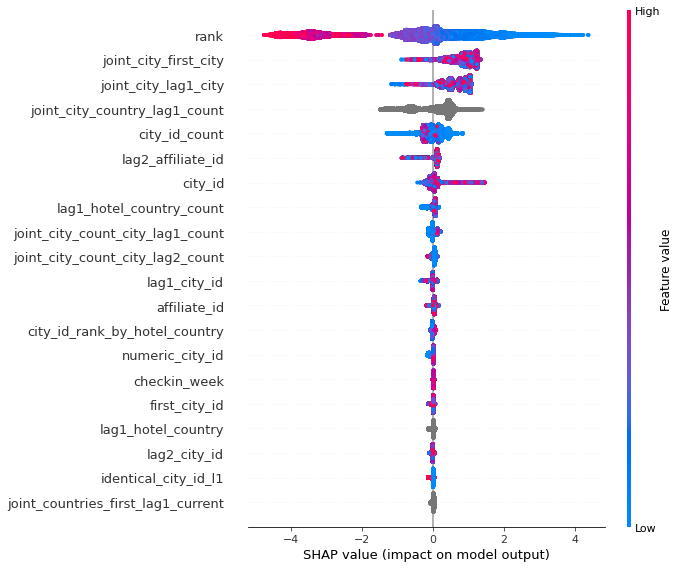

Wall time: 1min


In [68]:
%%time
explainer = shap.TreeExplainer(model)
sample_pool = Pool(data=X_test.head(100123),label = y_test.head(100123),cat_features=CAT_FEAT_NAMES,
                   group_id=X_test["utrip_id"].head(100123))
shap_values = explainer.shap_values(sample_pool)
# summarize the effects of all the features over all the data
shap.summary_plot(shap_values, X_test.head(100123))

In [69]:
# sample_pool = Pool(data=X_train.head(700123),label = y_train.head(700123),cat_features=CAT_FEAT_NAMES)
# shap_values = explainer.shap_values(sample_pool)
# # summarize the effects of all the features over all the data
# shap.summary_plot(shap_values, X_train.head(700123))

More models

In [70]:
# fit_cbr_model("QuerySoftMax") ##  slow - gets stuck. 

# # op 4 Accuracy: 57.8153